In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng()

In [2]:
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii

tng100.make_property(prop_behroozi_sfr, other_kws={'rng': rng}, overwrite=True, rename='sfr_behroozi', write=True)
tng100.make_property(prop_delooze_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'}, write=True)

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:296: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/siminterface/simhandler.py:582: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:350: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(property_name))


Assigning props for Snapshot 67.  


/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:296: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/siminterface/simhandler.py:582: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:350: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(property_name))


Assigning props for Snapshot 67.  


In [3]:
from simim.lightcone import LCMaker

gen = LCMaker(sim='TNG100-1',
              name='cii',
              openangle=1.0,
              aspect=1.0,
              mode = 'box',
              redshift_min = 0.5,
              redshift_max = 1.7,
              minimum_mass = 1e8)

gen.build_lightcones(rng=rng)
gen.add_properties('sfr_behroozi', 'LCII')

A file for light cones of this name already exists.
Light cones already saved may be overwritten.
Generating lines of sight.
Creating files and adding metadata.


In [4]:
from simim.lightcone import LCHandler
lc1 = LCHandler('TNG100-1','cii',0)
V = lc1.volume()

import simim.siminterface as sim
tng100 = sim.SimHandler('TNG100-1')
n = tng100.number_volumes(V)

print(f"The number of lightcones we can fit in the TNG100 volume is {n:.1f}")

The number of lightcones we can fit in the TNG100 volume is 7.9


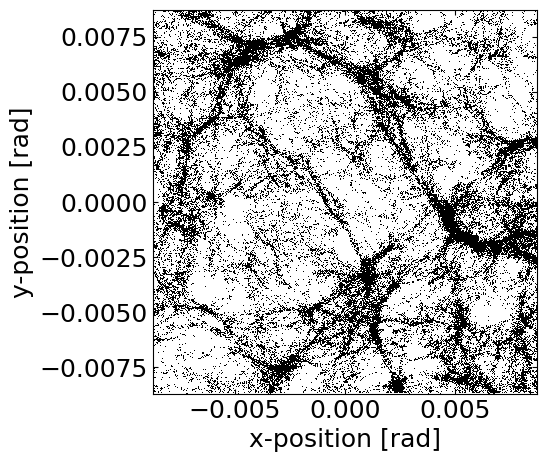

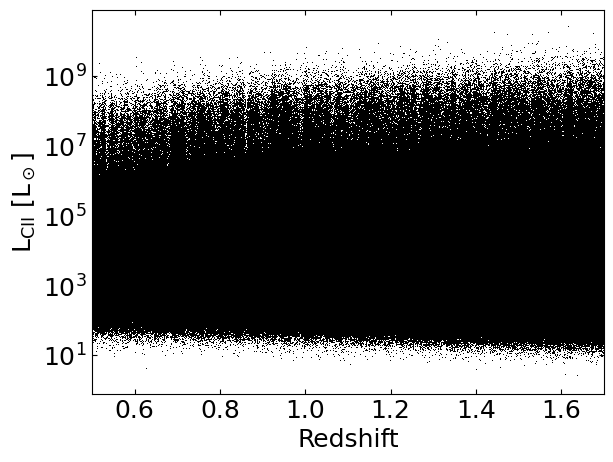

In [5]:
from simim.lightcone import LCHandler

lc1 = LCHandler('TNG100-1','cii',0)

lc1.set_property_range('redshift',0.999,1.001)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','LCII',
         axkws={'xlabel':'Redshift','ylabel':'L$_\mathregular{CII}$ [L$_\odot$]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

In [38]:
from simim import constants as sc

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = 1.5
d = tng100.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_cii * (1+z_for_modeling)**2 / (1000*tng100.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d    

conv = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26

tng100_snap = tng100.get_snap_from_z(z_for_modeling)

grid = tng100_snap.grid('LCII', res=pixel_size, norm=conv)

In [39]:
ps = grid.power_spectrum(in_place=True,normalize=True)

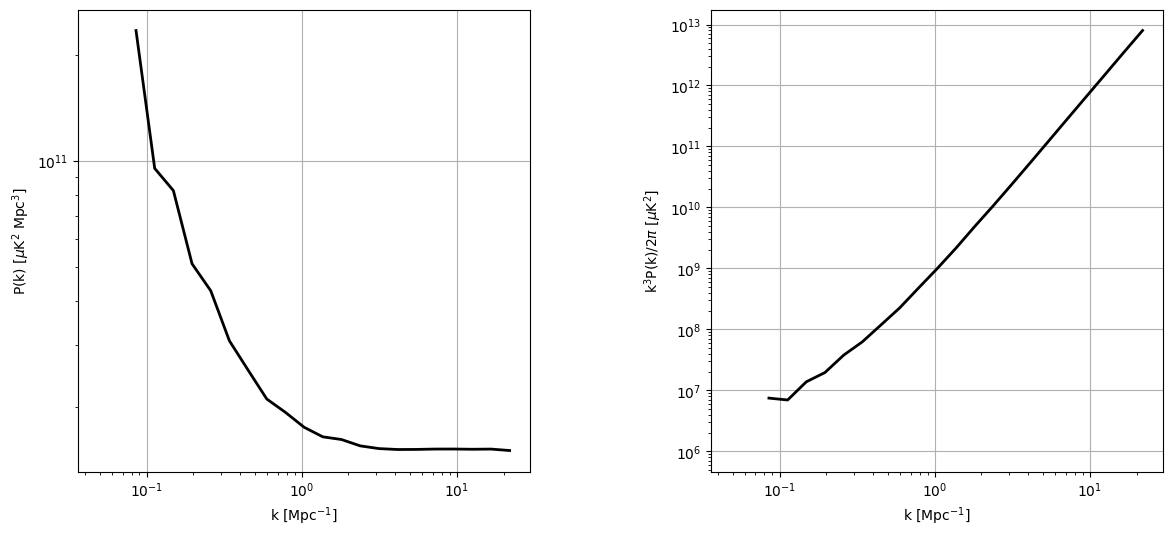

In [40]:
# Spherical average
bins = np.logspace(-3,3,51)
bin_centers = np.logspace(-2.95,2.95,50)
_,ps1d = ps.spherical_average(ax=[0,1,2],shells=bins)
ps1d = ps1d[:,0] / np.prod(grid.side_length)  # Normalize by volume
k = 2*np.pi * bin_centers

# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[0].plot(k,ps1d,lw=2,color='k')
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$\mu$K$^2$]',xscale='log',yscale='log')
ax[1].plot(k,k**3/2/np.pi**2*ps1d,lw=2,color='k')
ax[1].grid()
plt.show()
